In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import json
import warnings

warnings.filterwarnings('ignore')


Load and Explore Dataset

In [2]:
file_path = 'youtube-statistics.csv'
data = pd.read_csv(file_path, encoding='latin1')

In [3]:
print(data.head().to_string())

   rank                    Youtuber  subscribers   video views          category                       Title  uploads        Country Abbreviation   channel_type  video_views_rank  country_rank  channel_type_rank  video_views_for_the_last_30_days  lowest_monthly_earnings  highest_monthly_earnings  lowest_yearly_earnings  highest_yearly_earnings  subscribers_for_last_30_days  created_year created_month  created_date  Gross tertiary education enrollment (%)    Population  Unemployment rate  Urban_population   Latitude  Longitude
0     1                    T-Series    245000000  2.280000e+11             Music                    T-Series    20082          India           IN          Music               1.0           1.0                1.0                      2.258000e+09                 564600.0                9000000.00              6800000.00             1.084000e+08                     2000000.0        2006.0           Mar          13.0                                     28.1  1.366418

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   rank                                     995 non-null    int64  
 1   Youtuber                                 995 non-null    object 
 2   subscribers                              995 non-null    int64  
 3   video views                              995 non-null    float64
 4   category                                 949 non-null    object 
 5   Title                                    995 non-null    object 
 6   uploads                                  995 non-null    int64  
 7   Country                                  873 non-null    object 
 8   Abbreviation                             873 non-null    object 
 9   channel_type                             965 non-null    object 
 10  video_views_rank                         994 non-n

Handle Missing Values

In [5]:
for column in data.select_dtypes(include=np.number):
    data[column].fillna(data[column].median(), inplace=True)

for column in data.select_dtypes(include='object'):
    data[column].fillna(data[column].mode()[0], inplace=True)

Feature Engineering

In [6]:
data['views_per_upload'] = data['video views'] / data['uploads']

Handle Outliers

In [7]:
for column in data.select_dtypes(include=np.number).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

Feature Selection

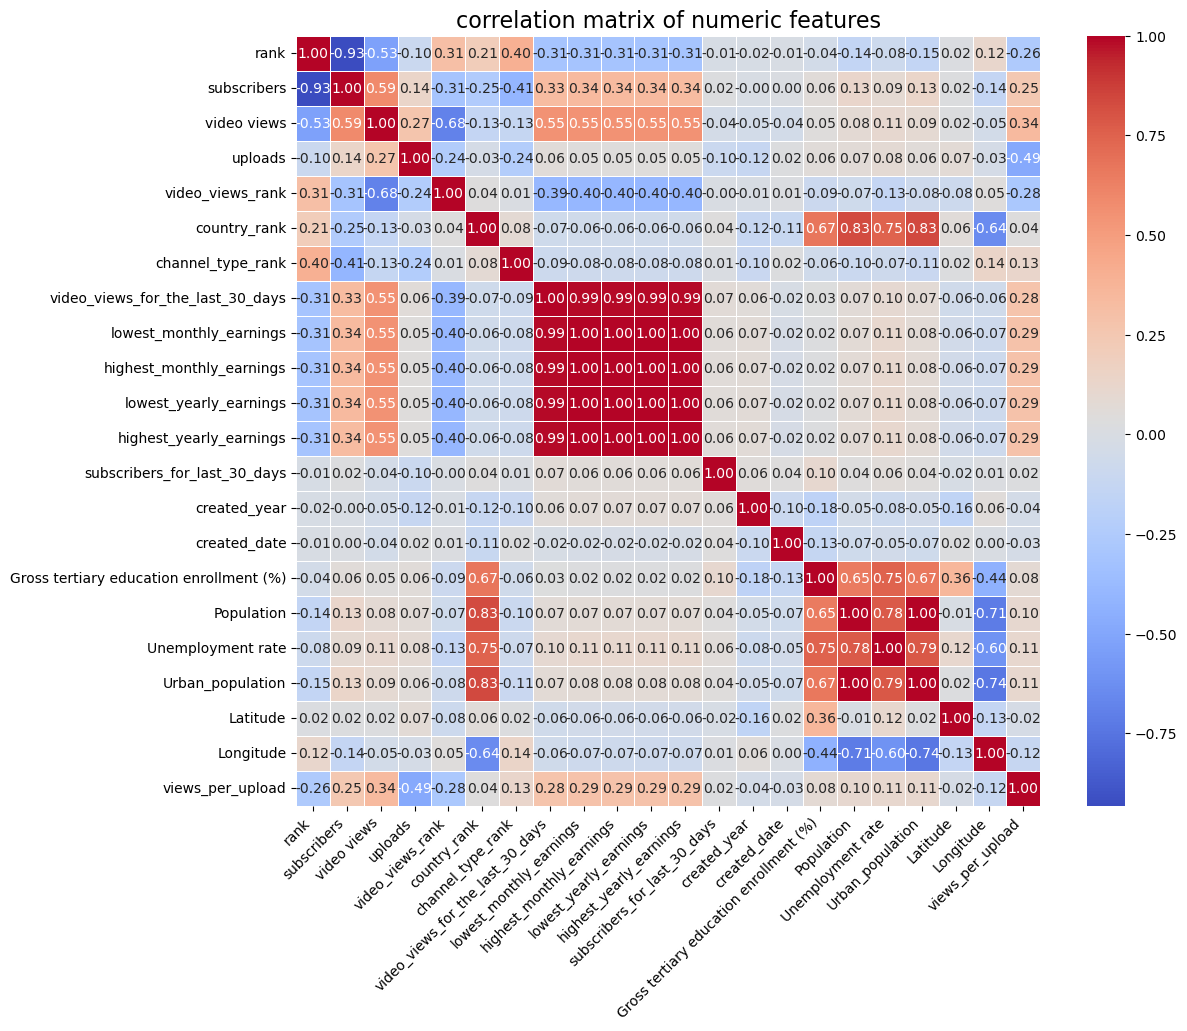

In [8]:
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

plt.title("correlation matrix of numeric features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

Encoding Non-Numeric Features

In [9]:
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns
label_encoders = {}
for column in non_numeric_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [10]:
selected_features = correlation_matrix['video views'][abs(correlation_matrix['video views']) > 0.3].index
selected_features = [feature for feature in selected_features if feature != 'video views']
print("selected Features-", selected_features)


selected Features- ['rank', 'subscribers', 'video_views_rank', 'video_views_for_the_last_30_days', 'lowest_monthly_earnings', 'highest_monthly_earnings', 'lowest_yearly_earnings', 'highest_yearly_earnings', 'views_per_upload']


Prepare Data for Modeling

In [11]:
X = data[selected_features]
y = data['video views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
print("X_train-")
print(X_train.head().to_string())
print("\nX_test-")
print(X_test.head().to_string())
print("\ny_train-")
print(y_train.head().to_string())
print("\ny_test-")
print(y_test.head().to_string())

X_train-
     rank  subscribers  video_views_rank  video_views_for_the_last_30_days  lowest_monthly_earnings  highest_monthly_earnings  lowest_yearly_earnings  highest_yearly_earnings  views_per_upload
447   448     18800000             483.0                        68006000.0                  17000.0                  272000.0                204000.0                3300000.0      1.810224e+07
374   375     20500000             377.0                       195203000.0                  48800.0                  780800.0                585600.0                9400000.0      3.719307e+07
358   359     20900000            1396.0                         2989000.0                      0.0                       0.0                     0.0                      0.0      5.018207e+06
410   411     19700000             747.0                        29387000.0                   7300.0                  117500.0                 88200.0                1400000.0      2.559295e+06
249   250     24600000    

Build and Evaluate Models

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[model_name] = {"MSE": mse, "R2": r2}
    print(f"{model_name} --> (MSE)- {mse}, (R2)- {r2}")

Linear Regression --> (MSE)- 6.13209042009342e+18, (R2)- 0.578432110095991
Lasso --> (MSE)- 5.990123543172264e+18, (R2)- 0.5881920243568447
Ridge --> (MSE)- 5.928913546946751e+18, (R2)- 0.5924000785736037
Decision Tree --> (MSE)- 3.838612397189043e+16, (R2)- 0.997361037399025
Random Forest --> (MSE)- 1.4734547782653902e+16, (R2)- 0.9989870318615869


Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

rf_predictions = best_rf.predict(X_test_scaled)
tuned_mse = mean_squared_error(y_test, rf_predictions)
tuned_r2 = r2_score(y_test, rf_predictions)
print(f"Tuned Random Forest - (MSE)- {tuned_mse}, (R2)- {tuned_r2}")

Tuned Random Forest - (MSE)- 1.6451559791774804e+16, (R2)- 0.9988689910174314


Compare Results

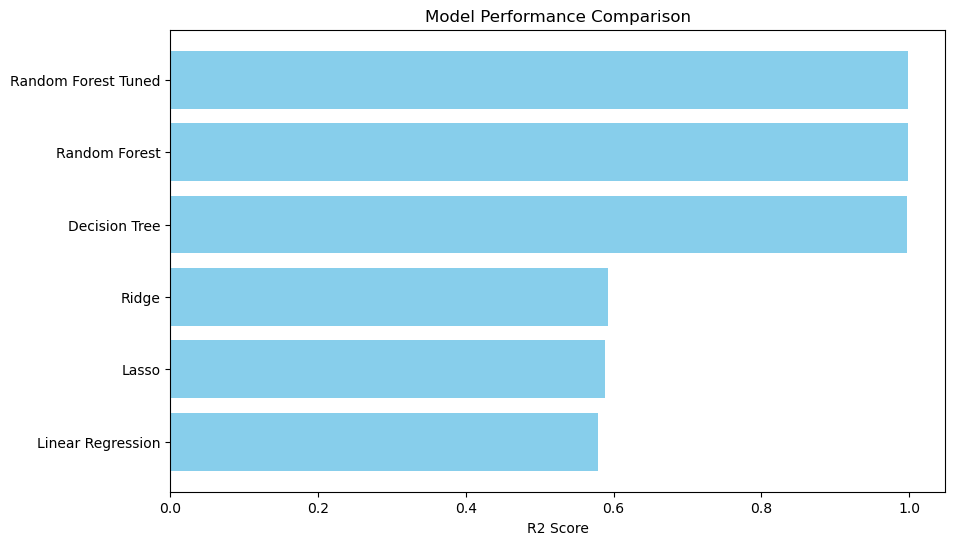

In [15]:
models["Random Forest Tuned"] = best_rf
results["Random Forest Tuned"] = {"MSE": tuned_mse, "R2": tuned_r2}

model_names = list(results.keys())
r2_scores = [results[model]["R2"] for model in model_names]

plt.figure(figsize=(10, 6))
plt.barh(model_names, r2_scores, color='skyblue')
plt.xlabel("R2 Score")
plt.title("Model Performance Comparison")
plt.show()

In [16]:
final_predictions = best_rf.predict(X_test_scaled)
predictions_dict = {'predictions': final_predictions.tolist()}
with open('./model/predictions.json', 'w') as f:
    json.dump(predictions_dict, f)
print("Predictions saved successfully!")

Predictions saved successfully!


In [17]:
import joblib

joblib.dump(best_rf, './model/best_rf.pkl')
joblib.dump(scaler, './model/scaler.pkl')

['./model/scaler.pkl']